In [1]:
import scanorama
print(scanorama.__version__)

1.7.4


In [6]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
import os
import urllib.request

warnings.simplefilter(action='ignore', category=Warning)

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3             

sc.settings.set_figure_params(dpi=80)
%matplotlib inline

In [7]:
# download pre-computed data if missing or long compute
fetch_data = True

# url for source and intermediate data
path_data = "https://export.uppmax.uu.se/naiss2023-23-3/workshops/workshop-scrnaseq"

path_results = "data/covid/results"
if not os.path.exists(path_results):
    os.makedirs(path_results, exist_ok=True)

path_file = "data/covid/results/scanpy_covid_qc_dr.h5ad"
if fetch_data and not os.path.exists(path_file):
    urllib.request.urlretrieve(os.path.join(
        path_data, 'covid/results/scanpy_covid_qc_dr.h5ad'), path_file)

adata = sc.read_h5ad(path_file)
adata

AnnData object with n_obs × n_vars = 7222 × 2626
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'phase_colors', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
print(adata.X.shape)

(7222, 2626)


In [9]:
adata2 = adata.raw.to_adata() 

# in some versions of Anndata there is an issue with information on the logtransformation in the slot log1p.base so we set it to None to not get errors.
adata2.uns['log1p']['base']=None

# check that the matrix looks like normalized counts
print(adata2.X[1:10,1:10])

  (0, 3)	0.7825693876867097
  (7, 6)	1.1311041336746985


In [10]:
var_genes_all = adata.var.highly_variable

print("Highly variable genes: %d"%sum(var_genes_all))

Highly variable genes: 2626


In [11]:
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'sample')

print("Highly variable genes intersection: %d"%sum(adata2.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata2.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata2.var.highly_variable_nbatches > 0

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes intersection: 122
Number of batches where gene is variable:
highly_variable_nbatches
0    7876
1    4163
2    3161
3    2025
4    1115
5     559
6     277
7     170
8     122
Name: count, dtype: int64


In [12]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(adata2.var.highly_variable_nbatches == 6))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & adata2.var.highly_variable_intersection))

Any batch var genes: 11592
All data var genes: 2626
Overlap: 2625
Variable genes in all batches: 277
Overlap batch instersection and all: 122


In [13]:
var_select = adata2.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]
len(var_genes)

4268

In [15]:
import bbknn
bbknn.bbknn(adata2,batch_key='sample')

# then run umap on the integrated space
sc.tl.umap(adata2)
sc.tl.tsne(adata2)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:09)


<Axes: title={'center': 'Uncorrected umap'}, xlabel='UMAP1', ylabel='UMAP2'>

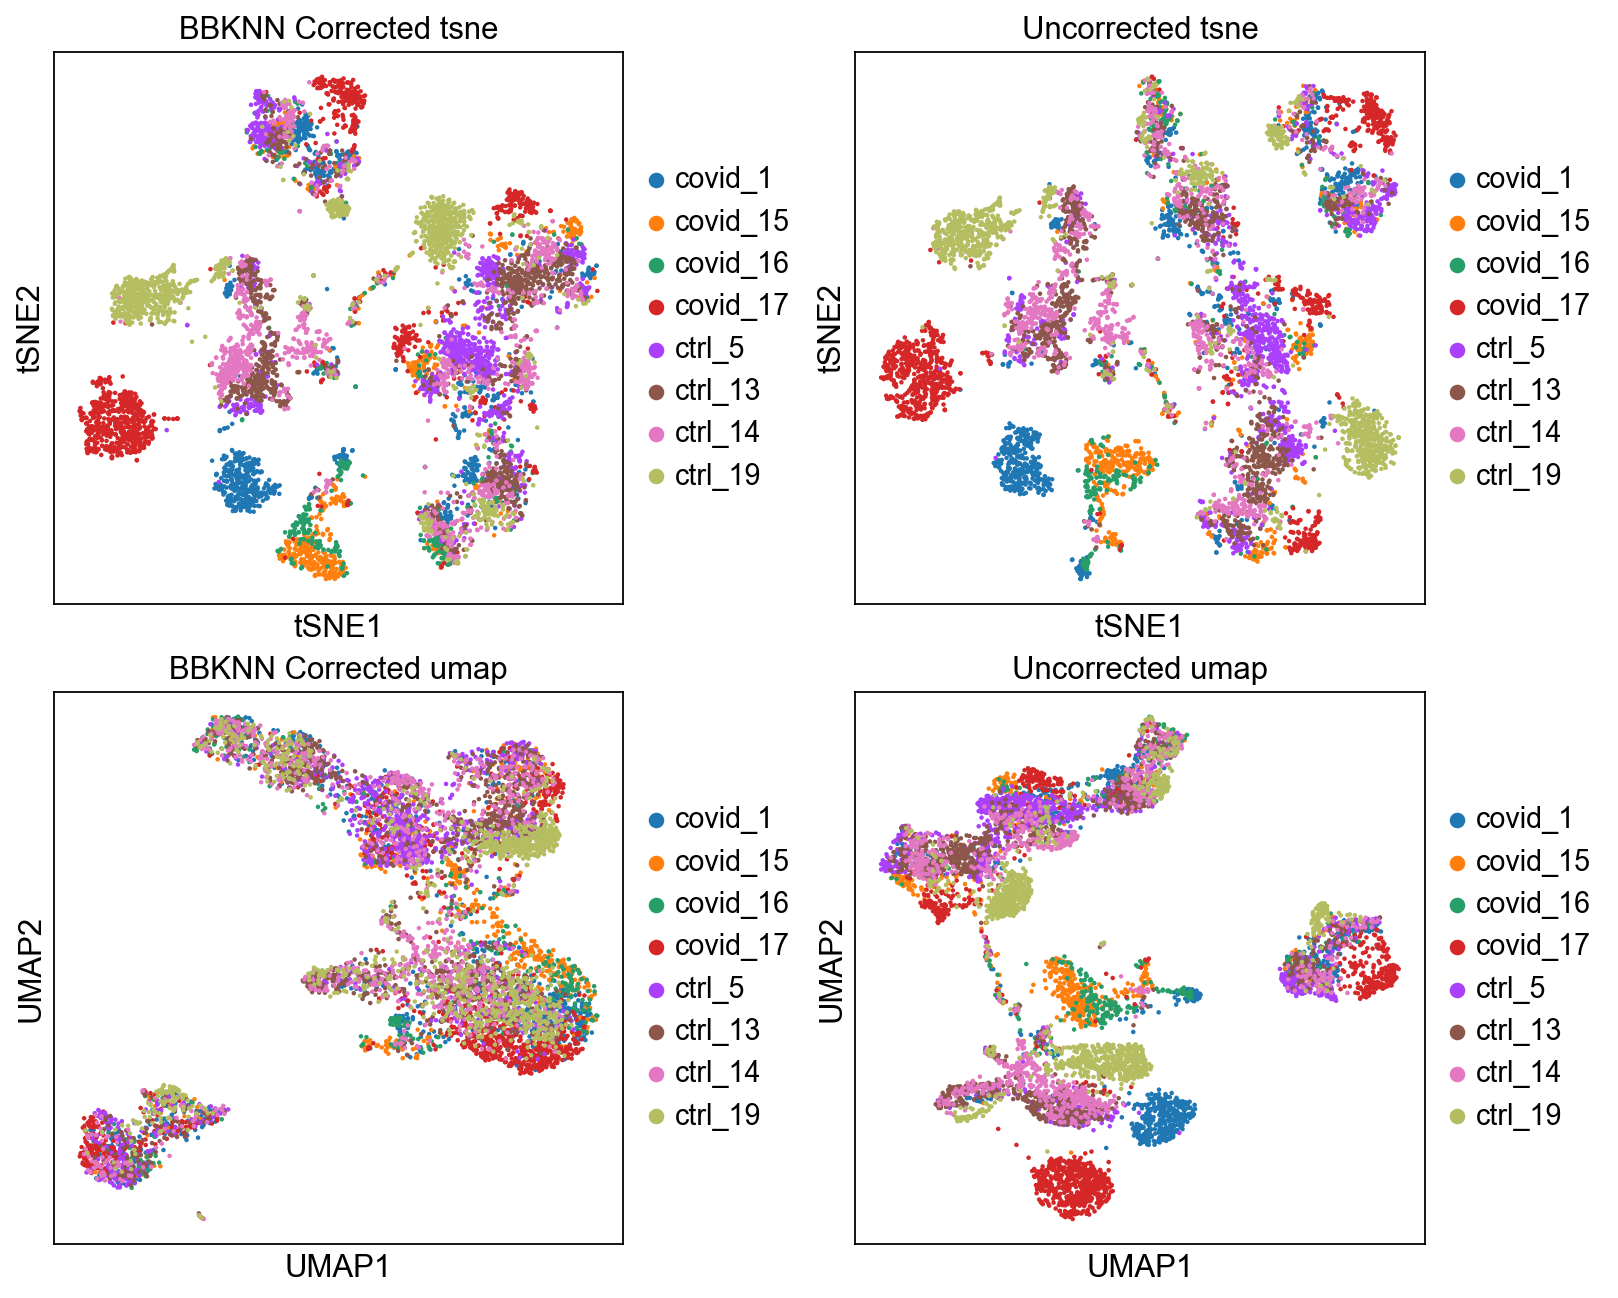

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10,8),constrained_layout=True)
sc.pl.tsne(adata2, color="sample", title="BBKNN Corrected tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata, color="sample", title="Uncorrected tsne", ax=axs[0,1], show=False)
sc.pl.umap(adata2, color="sample", title="BBKNN Corrected umap", ax=axs[1,0], show=False)
sc.pl.umap(adata, color="sample", title="Uncorrected umap", ax=axs[1,1], show=False)

In [17]:
# create a new object with lognormalized counts
adata_combat = sc.AnnData(X=adata.raw.X, var=adata.raw.var, obs = adata.obs)

# first store the raw data 
adata_combat.raw = adata_combat

# run combat
sc.pp.combat(adata_combat, key='sample')

Standardizing Data across genes.

Found 8 batches

Found 0 numerical variables:
	

Found 39 genes with zero variance.
Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes: 3923


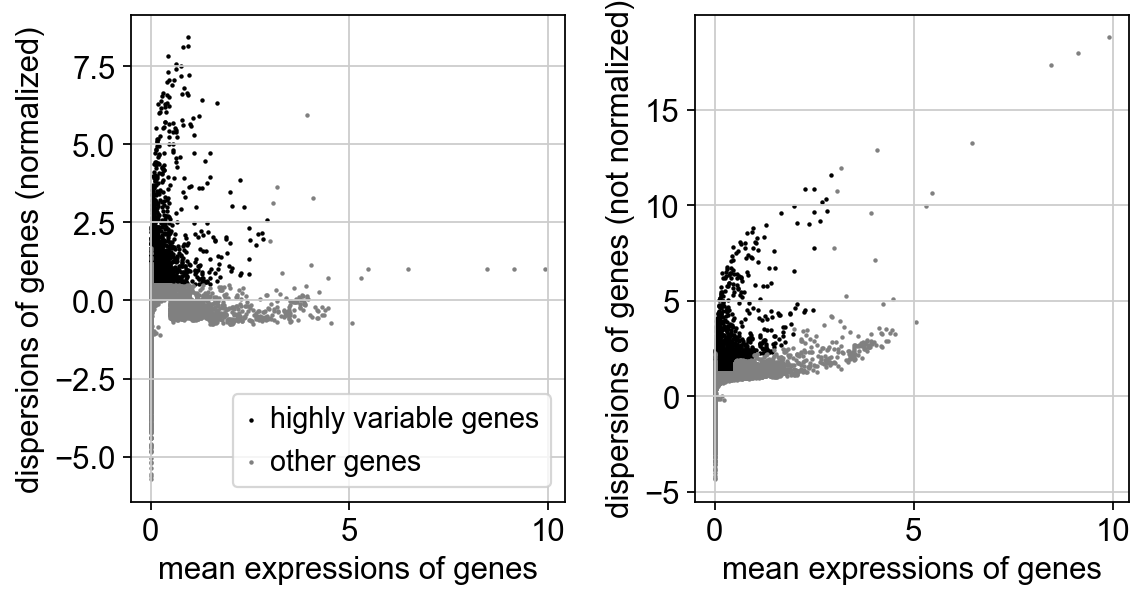

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:20)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
computing tSNE
    using 'X_pca' with n_pcs = 30
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:09)


In [18]:
sc.pp.highly_variable_genes(adata_combat)
print("Highly variable genes: %d"%sum(adata_combat.var.highly_variable))
sc.pl.highly_variable_genes(adata_combat)

sc.pp.pca(adata_combat, n_comps=30, use_highly_variable=True, svd_solver='arpack')

sc.pp.neighbors(adata_combat)

sc.tl.umap(adata_combat)
sc.tl.tsne(adata_combat)

In [19]:
# compare var_genes
var_genes_combat = adata_combat.var.highly_variable
print("With all data %d"%sum(var_genes_all))
print("With combat %d"%sum(var_genes_combat))
print("Overlap %d"%sum(var_genes_all & var_genes_combat))

print("With 2 batches %d"%sum(var_select))
print("Overlap %d"%sum(var_genes_combat & var_select))

With all data 2626
With combat 3923
Overlap 1984
With 2 batches 4268
Overlap 2729


<Axes: title={'center': 'Combat umap'}, xlabel='UMAP1', ylabel='UMAP2'>

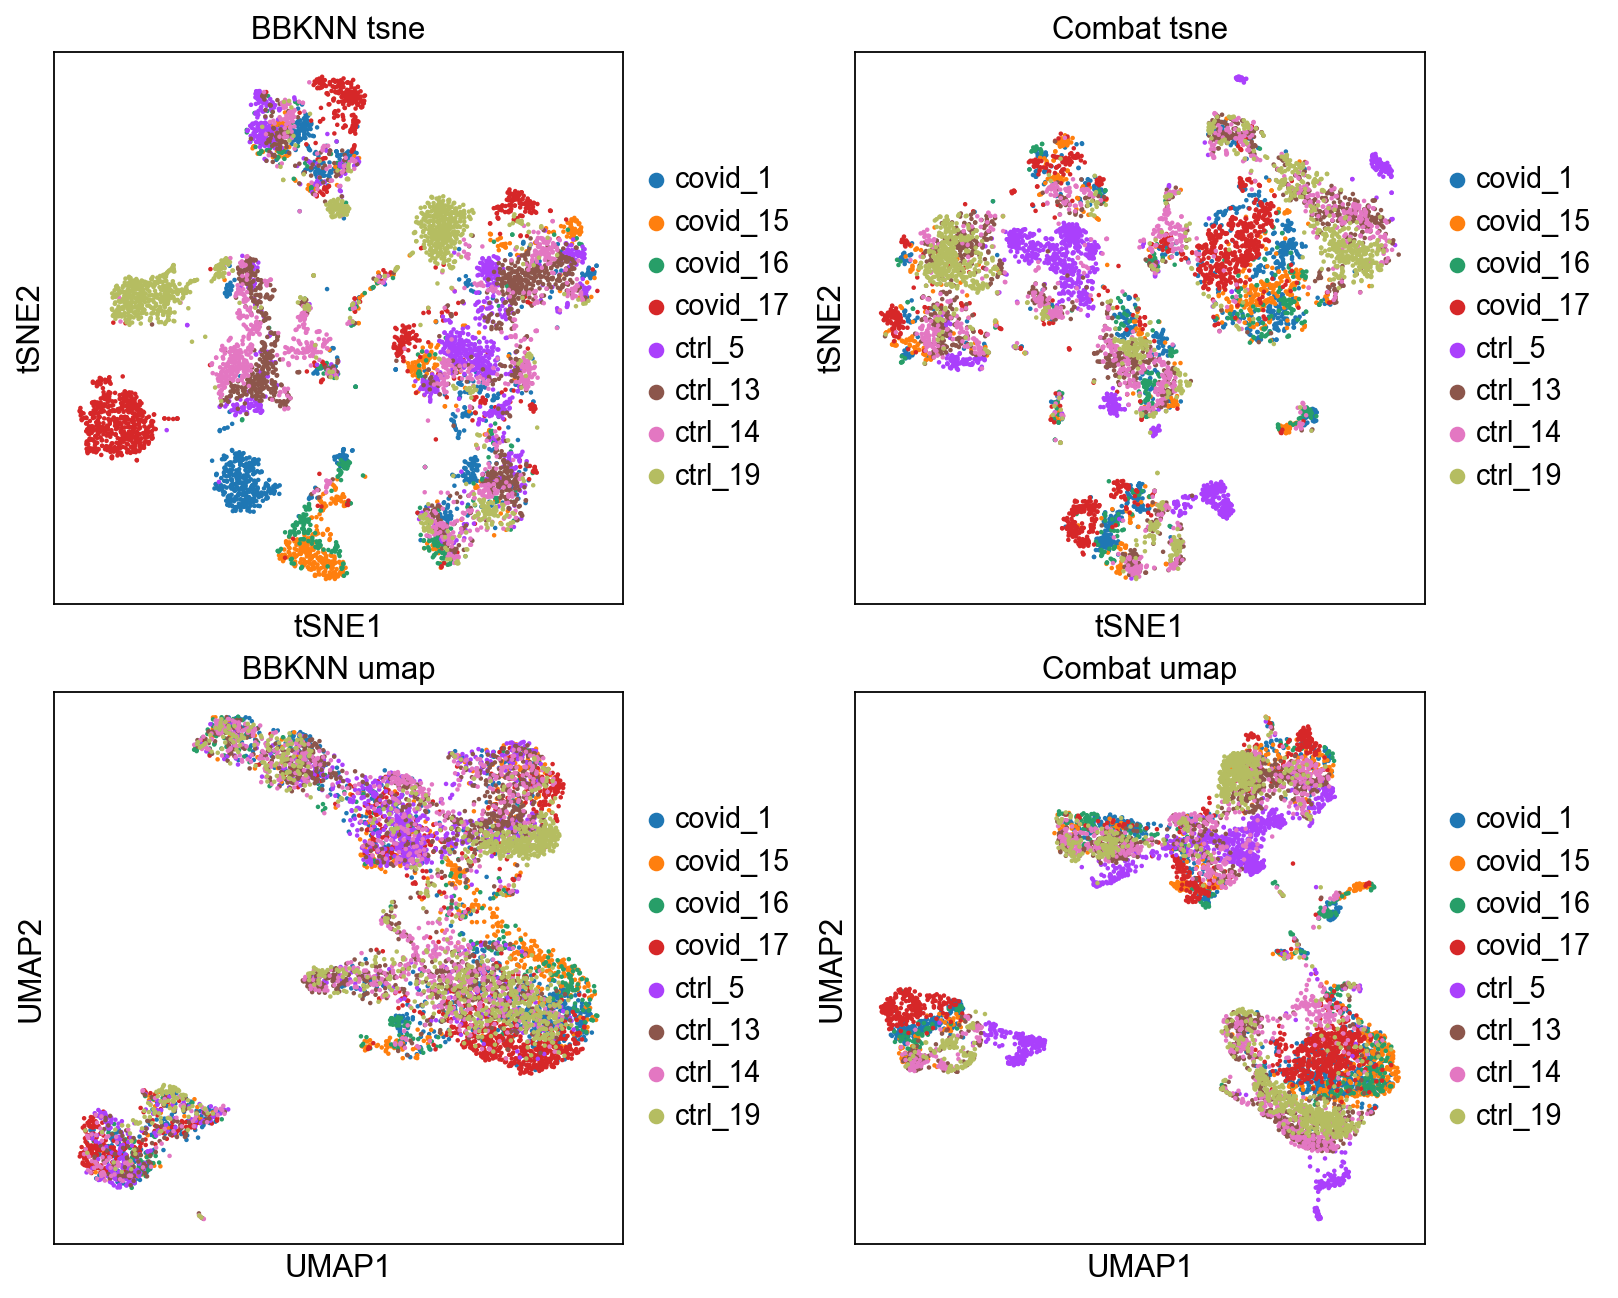

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(10,8),constrained_layout=True)
sc.pl.tsne(adata2, color="sample", title="BBKNN tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata_combat, color="sample", title="Combat tsne", ax=axs[0,1], show=False)
sc.pl.umap(adata2, color="sample", title="BBKNN umap", ax=axs[1,0], show=False)
sc.pl.umap(adata_combat, color="sample", title="Combat umap", ax=axs[1,1], show=False)

In [21]:
#save to file
save_file = './data/covid/results/scanpy_covid_qc_dr_combat.h5ad'
adata_combat.write_h5ad(save_file)

In [22]:
# split per batch into new objects.
batches = adata.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata2[adata2.obs['sample'] == batch,]

alldata   

{'covid_1': View of AnnData object with n_obs × n_vars = 876 × 19468
     obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'phase_colors', 'sample_colors', 'tsne', 'umap'
     obsm: 'X_pca', 'X_tsne', 'X_umap'
     obsp: 'connectivities', 'distances',
 'covid_15': View of AnnData object with n_obs × n_vars = 591 × 19468
     obs: 'type', 'sample', 'batch', 'n_g

In [23]:
import scanorama

#subset the individual dataset to the variable genes we defined at the beginning
alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes]

#convert to list of AnnData objects
adatas = list(alldata2.values())

# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 50)

covid_1
covid_15
covid_16
covid_17
ctrl_5
ctrl_13
ctrl_14
ctrl_19
Found 4268 genes among all datasets
[[0.         0.53637902 0.52162162 0.27767528 0.57876712 0.48515982
  0.36643836 0.10856134]
 [0.         0.         0.8027027  0.31810491 0.43362832 0.24703892
  0.29780034 0.16582064]
 [0.         0.         0.         0.25675676 0.4972973  0.53243243
  0.44864865 0.3027027 ]
 [0.         0.         0.         0.         0.2359882  0.08210332
  0.12546125 0.18005296]
 [0.         0.         0.         0.         0.         0.84562439
  0.75221239 0.27007944]
 [0.         0.         0.         0.         0.         0.
  0.83407672 0.46337158]
 [0.         0.         0.         0.         0.         0.
  0.         0.78817299]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]
Processing datasets (4, 5)
Processing datasets (5, 6)
Processing datasets (1, 2)
Processing datasets (6, 7)
Processing datasets (4, 6)
Processing datasets (0, 4)
Processing data

In [24]:
#scanorama adds the corrected matrix to adata.obsm in each of the datasets in adatas.
adatas[0].obsm['X_scanorama'].shape

(876, 50)

In [25]:
# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]

# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# add to the AnnData object, create a new object first
adata_sc = adata.copy()
adata_sc.obsm["Scanorama"] = all_s

(7222, 50)


In [26]:
# tsne and umap
sc.pp.neighbors(adata_sc, n_pcs =30, use_rep = "Scanorama")
sc.tl.umap(adata_sc)
sc.tl.tsne(adata_sc, n_pcs = 30, use_rep = "Scanorama")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:09)


<Axes: title={'center': 'Scanorama umap'}, xlabel='UMAP1', ylabel='UMAP2'>

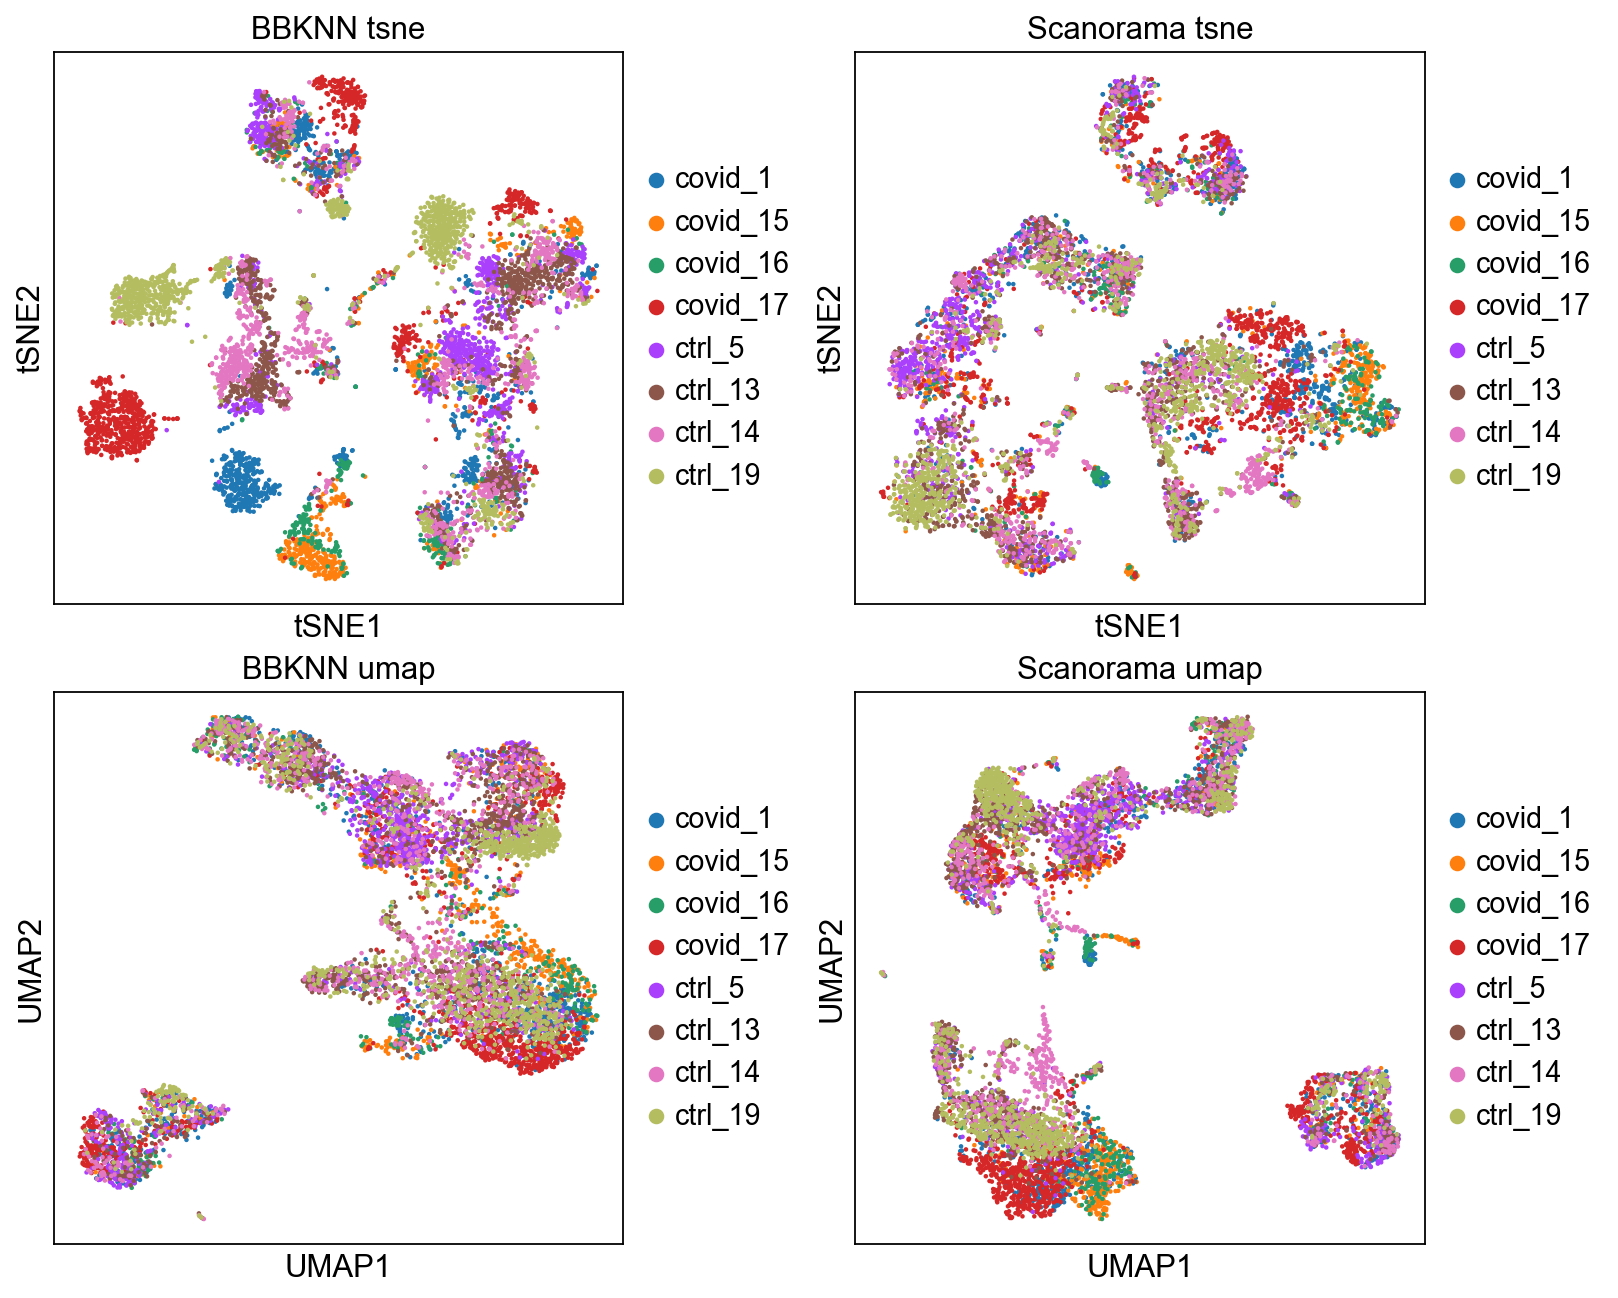

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(10,8),constrained_layout=True)
sc.pl.tsne(adata2, color="sample", title="BBKNN tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata_sc, color="sample", title="Scanorama tsne", ax=axs[0,1], show=False)
sc.pl.umap(adata2, color="sample", title="BBKNN umap", ax=axs[1,0], show=False)
sc.pl.umap(adata_sc, color="sample", title="Scanorama umap", ax=axs[1,1], show=False)

In [28]:
#save to file
save_file = './data/covid/results/scanpy_covid_qc_dr_scanorama.h5ad'
adata_sc.write_h5ad(save_file)

<Axes: title={'center': 'Scanorama'}, xlabel='UMAP1', ylabel='UMAP2'>

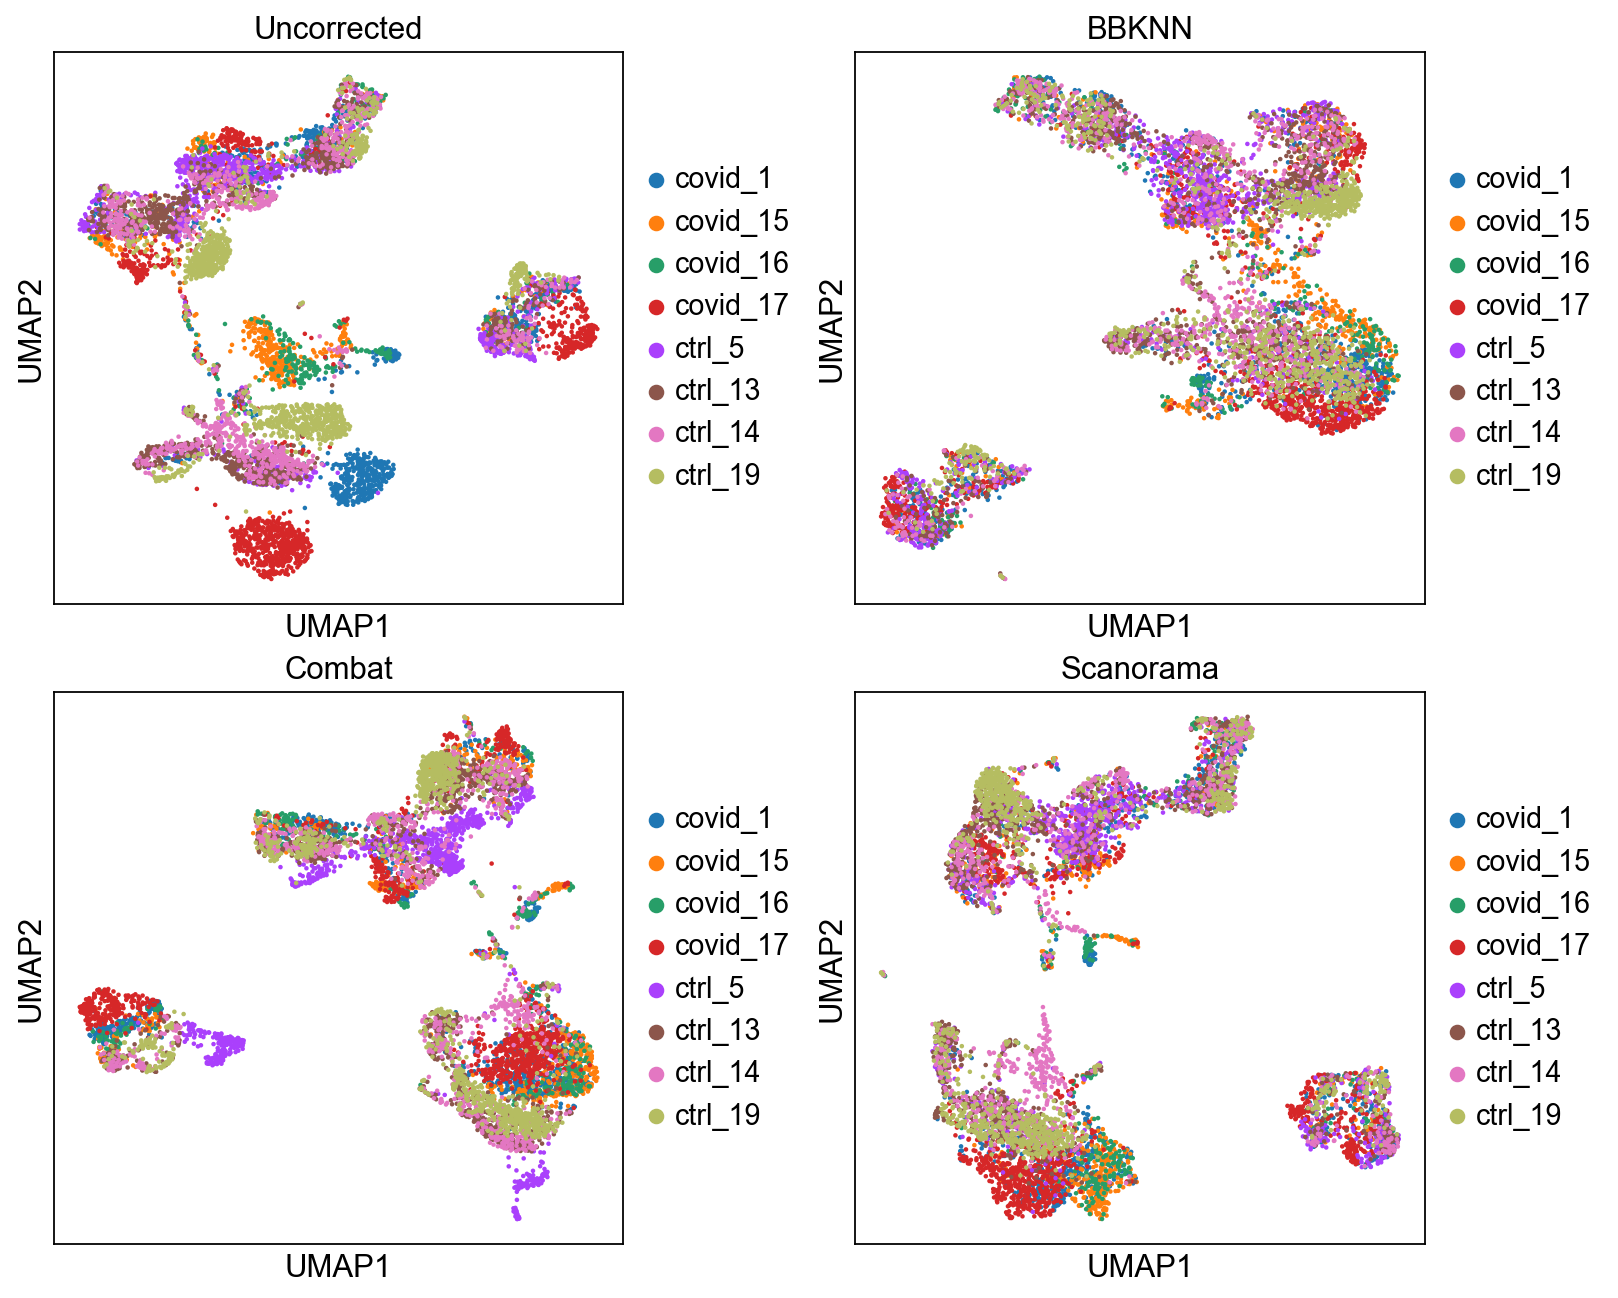

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(10,8),constrained_layout=True)
sc.pl.umap(adata, color="sample", title="Uncorrected", ax=axs[0,0], show=False)
sc.pl.umap(adata2, color="sample", title="BBKNN", ax=axs[0,1], show=False)
sc.pl.umap(adata_combat, color="sample", title="Combat", ax=axs[1,0], show=False)
sc.pl.umap(adata_sc, color="sample", title="Scanorama", ax=axs[1,1], show=False)